In [1]:
%load_ext autoreload
%autoreload 2
from functools import partial

import keras

from datasets import example_datasets, to_numpy
from models import mixture_poissons,location_specific_linear, CustomPenalizedMixtureDecisionModel
from metrics import mixture_poi_loss, get_bpr_loss_func, mix_bpr, get_penalized_bpr_loss_func_mix, cross_ratio_decision, get_perturbed_bpr_func
from experiments import training_loop, training_loop_score_function_trick, score_function_trick, overall_gradient_calculation
from plotting_funcs import plot_losses, plot_frontier

import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np

import matplotlib.pyplot as plt

2024-05-11 22:10:53.797480: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-11 22:10:53.854404: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-11 22:10:53.854436: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-11 22:10:53.855582: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-11 22:10:53.863716: I tensorflow/core/platform/cpu_feature_guar

In [2]:
seed=360
num_components=4
learning_rate = 0.005
epochs=500
outdir = '/cluster/home/kheuto01/testdir'
penalty = 5000
threshold = 0.55
K=4
do_only=True
# tracts/distributions
S=12
# history/features
H = 3
# total timepoints
T= 500
perturbed_sigma=0.1
num_score_func_samples=2

In [9]:
train_dataset, val_dataset, test_dataset = example_datasets(H, T, seed=seed)
train_X_THS, train_y_TS = to_numpy(train_dataset)
val_X_THS, val_y_TS = to_numpy(val_dataset)
input_shape = (H,S)

bpr_K = get_perturbed_bpr_func(K, sigma=perturbed_sigma)
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)


In [10]:
model, mix_weights  = mixture_poissons(location_specific_linear, input_shape, num_components=num_components)

In [34]:
training_loop_score_function_trick(model, optimizer, epochs, train_dataset, val_dataset,
                                       cross_ratio_decision, bpr_K,
                                       objective_includes_likelihood=True,
                                       objective_includes_bpr=True,
                                       bpr_threshold=threshold,
                                       penalty=penalty,
                                       num_score_func_samples=num_score_func_samples,
                                       verbose=True)

Epoch 0
Loss: 655.6746215820312
NLL: -133.47491455078125
BPR: 0.5035321712493896
Epoch 1


In [11]:
#check numerics
tf.debugging.enable_check_numerics()

losses = {}
losses['train'] = {}
losses['val'] ={}
losses['train']['loss']=[]
losses['train']['nll']=[]
losses['train']['bpr']=[]
losses['val']['loss']=[]
losses['val']['nll']=[]
losses['val']['bpr']=[]
verbose=True
for epoch in range(1):
        if verbose:
            print(f'Epoch {epoch}')
        else:
            if epoch % 10 == 0:
                print(f'Epoch {epoch}')

        for step, (x_BHS, y_BS) in enumerate(train_dataset):
            
            with tf.GradientTape() as jacobian_tape, tf.GradientTape() as loss_tape:
                prob_params_BSK, mixture_weights_KS = model(x_BHS, training=True)

                # my fault that model returns KS instead of SK
                mixture_weights_SK = tf.transpose(mixture_weights_KS, perm=[1,0])

                #  could create a custom model class that returns 
                # the appropriate tfp.dist given outputs
                mix = tfp.distributions.MixtureSameFamily(
                    mixture_distribution=tfp.distributions.Categorical(probs=mixture_weights_SK),
                    components_distribution = tfp.distributions.Poisson(rate=prob_params_BSK+1e-13))

                # add constant to avoid log 0
                sample_y_MBS = mix.sample(num_score_func_samples)+1e-13

                sample_log_probs_MBS = mix.log_prob(sample_y_MBS)
                sample_decisions_MBS = cross_ratio_decision(sample_y_MBS)
                expected_decisions_BS = tf.reduce_mean(sample_decisions_MBS, axis=0)
                bpr_B = bpr_K(y_BS, expected_decisions_BS)
                observed_log_prob_BS = mix.log_prob(y_BS)

                loss_B = tf.zeros_like(bpr_B)

                if True:
                    loss_B -= tf.reduce_sum(observed_log_prob_BS, axis=-1)
                if True:
                    violate_threshold_flag_B = tf.cast(tf.greater(threshold,
                                                                bpr_B),
                                                        tf.float32)
                    loss_B += penalty * violate_threshold_flag_B *(threshold - bpr_B)

            losses['train']['loss'].append(tf.reduce_mean(loss_B))
            losses['train']['nll'].append(tf.reduce_mean(tf.reduce_sum(observed_log_prob_BS, axis=-1)))
            losses['train']['bpr'].append(tf.reduce_mean(bpr_B))
            
            if verbose:
                # print all metrics
                print(f'Loss: {losses["train"]["loss"][-1]}')
                print(f'NLL: {losses["train"]["nll"][-1]}')
                print(f'BPR: {losses["train"]["bpr"][-1]}')
            
            # The lowercase "p" signifies that these are lists of length P, P = number of trainable variables
            jacobian_pMBS = jacobian_tape.jacobian(sample_log_probs_MBS, model.trainable_weights)
            param_gradient_pBS = [score_function_trick(j, sample_decisions_MBS) for j in jacobian_pMBS]

            loss_gradients_BS = loss_tape.gradient(loss_B, expected_decisions_BS)
            overall_gradient = [overall_gradient_calculation(g, loss_gradients_BS) for g in param_gradient_pBS]

            # Run one step of gradient descent by updating
            # the value of the variables to minimize the loss.
            optimizer.apply_gradients(zip(overall_gradient, model.trainable_weights))

            
                
            

            


INFO:tensorflow:Enabled check-numerics callback in thread MainThread


Epoch 0
Loss: 667.5817260742188
NLL: -133.47491455078125
BPR: 0.5065986514091492


InvalidArgumentError: Graph execution error:

Detected at node gradient_tape/MixtureSameFamily/log_prob/Poisson/log_prob/Shape_2/CheckNumericsV2 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/pip_k2_tf/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/pip_k2_tf/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/pip_k2_tf/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/pip_k2_tf/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/pip_k2_tf/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/pip_k2_tf/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/pip_k2_tf/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/pip_k2_tf/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 542, in dispatch_queue

  File "/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/pip_k2_tf/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 531, in process_one

  File "/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/pip_k2_tf/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/pip_k2_tf/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 359, in execute_request

  File "/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/pip_k2_tf/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 775, in execute_request

  File "/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/pip_k2_tf/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 446, in do_execute

  File "/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/pip_k2_tf/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/pip_k2_tf/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell

  File "/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/pip_k2_tf/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell

  File "/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/pip_k2_tf/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/pip_k2_tf/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async

  File "/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/pip_k2_tf/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes

  File "/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/pip_k2_tf/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipykernel_33876/463751284.py", line 65, in <module>

  File "/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/pip_k2_tf/lib/python3.11/site-packages/tensorflow/python/ops/parallel_for/control_flow_ops.py", line 212, in f

  File "/cluster/tufts/hugheslab/kheuto01/mambaforge/envs/pip_k2_tf/lib/python3.11/site-packages/tensorflow/core/function/capture/capture_container.py", line 125, in capture_by_value

!!! Detected Infinity or NaN in output 0 of graph op "Const" (# of outputs: 1) !!!
  dtype: <dtype: 'float32'>
  shape: ()
  Graph name: "f"

  Stack trace of op's creation ("->": inferred user code):
    + ... (Omitted 29 frames)
    + .../eager/polymorphic_function/tracing_compilation.py (L178) trace_function
    |   
    + .../eager/polymorphic_function/tracing_compilation.py (L283) _maybe_define_function
    |   
    + .../eager/polymorphic_function/tracing_compilation.py (L310) _create_concrete_function
    |   
    + ...packages/tensorflow/python/framework/func_graph.py (L1059) func_graph_from_py_func
    |   
    + ...eager/polymorphic_function/polymorphic_function.py (L598) wrapped_fn
    |   
    + ...ython/eager/polymorphic_function/autograph_util.py (L41) autograph_handler
    |   
    + ...orflow/python/ops/parallel_for/control_flow_ops.py (L212) f
    |   
    + ...orflow/python/ops/parallel_for/control_flow_ops.py (L309) _pfor_impl
    |   
    + .../site-packages/tensorflow/python/eager/backprop.py (L1160) loop_fn
    |   
    + .../site-packages/tensorflow/python/eager/backprop.py (L1066) gradient
    |   
    + ...ackages/tensorflow/python/eager/imperative_grad.py (L67) imperative_grad
    |   
    + .../site-packages/tensorflow/python/eager/backprop.py (L148) _gradient_function
    |   
    + ...1/site-packages/tensorflow/python/ops/math_grad.py (L1657) _SelectGradV2
    |   
    + ...1/site-packages/tensorflow/python/ops/math_grad.py (L142) _ReduceGradientArgs
    |   
    + ...1/site-packages/tensorflow/python/ops/math_grad.py (L75) SmartBroadcastGradientArgs
    |   
    + ...packages/tensorflow/python/util/traceback_utils.py (L150) error_handler
    |   
    + ...1/site-packages/tensorflow/python/util/dispatch.py (L1260) op_dispatch_handler
    |   
    + ...1/site-packages/tensorflow/python/ops/array_ops.py (L688) shape
    |   
    + ...1/site-packages/tensorflow/python/ops/array_ops.py (L718) shape_internal
    |   
    + .../site-packages/tensorflow/python/profiler/trace.py (L183) wrapped
    |   
    + ...1/site-packages/tensorflow/python/framework/ops.py (L696) convert_to_tensor
    |   
    + ...low/python/framework/tensor_conversion_registry.py (L209) convert
    |   
    + ...1/site-packages/tensorflow/python/framework/ops.py (L590) __tf_tensor__
    |   
    + ...packages/tensorflow/python/framework/func_graph.py (L675) capture
    |   
    + ...sorflow/core/function/capture/capture_container.py (L125) capture_by_value
    |   
    + ...1/site-packages/tensorflow/python/framework/ops.py (L603) _capture_as_const
    |   
    + ...1/site-packages/tensorflow/python/framework/ops.py (L268) _create_graph_constant
    |   
    + ...packages/tensorflow/python/framework/func_graph.py (L670) _create_op_internal
    |   
    + ...1/site-packages/tensorflow/python/framework/ops.py (L2652) _create_op_internal
    |   
    + ...1/site-packages/tensorflow/python/framework/ops.py (L1160) from_node_def
    |   

 : Tensor had -Inf values
	 [[{{node gradient_tape/MixtureSameFamily/log_prob/Poisson/log_prob/Shape_2/CheckNumericsV2}}]] [Op:__inference_f_5832]

In [6]:
model.trainable_weights

[<tf.Variable 'linear_convolution/kernel:0' shape=(1, 3, 1) dtype=float32, numpy=
 array([[[ 0.33118924],
         [-0.46106085],
         [-0.2423242 ]]], dtype=float32)>,
 <tf.Variable 'linear_convolution/bias:0' shape=(1,) dtype=float32, numpy=array([0.00499997], dtype=float32)>,
 <tf.Variable 'linear_convolution/kernel:0' shape=(1, 3, 1) dtype=float32, numpy=
 array([[[1.176708  ],
         [0.85288453],
         [1.1648061 ]]], dtype=float32)>,
 <tf.Variable 'linear_convolution/bias:0' shape=(1,) dtype=float32, numpy=array([-0.00499997], dtype=float32)>,
 <tf.Variable 'linear_convolution/kernel:0' shape=(1, 3, 1) dtype=float32, numpy=
 array([[[ 0.47222552],
         [-0.03634611],
         [ 0.96142197]]], dtype=float32)>,
 <tf.Variable 'linear_convolution/bias:0' shape=(1,) dtype=float32, numpy=array([0.00499997], dtype=float32)>,
 <tf.Variable 'linear_convolution/kernel:0' shape=(1, 3, 1) dtype=float32, numpy=
 array([[[nan],
         [nan],
         [nan]]], dtype=float32)>,
 

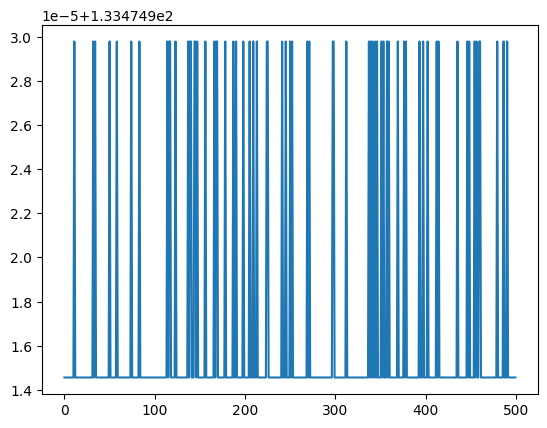

In [16]:
plt.plot(losses['train']['loss'])

In [20]:
# The lowercase "p" signifies that these are lists of length P, P = number of trainable variables
jacobian_pMBS = jacobian_tape.jacobian(sample_log_probs_MBS, model.trainable_weights)
param_gradient_pBS = [score_function_trick(j, sample_decisions_MBS) for j in jacobian_pMBS]

loss_gradients_BS = loss_tape.gradient(loss_B, expected_decisions_BS)
overall_gradient = [overall_gradient_calculation(g, loss_gradients_BS) for g in param_gradient_pBS]

# Run one step of gradient descent by updating
# the value of the variables to minimize the loss.
optimizer.apply_gradients(zip(overall_gradient, model.trainable_weights))

IndentationError: unexpected indent (1432462443.py, line 2)

In [32]:
# The lowercase "p" signifies that these are lists of length P, P = number of trainable variables
jacobian_pMBS = jacobian_tape.jacobian(sample_log_probs_MBS, model.trainable_weights)
param_gradient_pBS = [score_function_trick(j, sample_decisions_MBS) for j in jacobian_pMBS]


loss_gradients_BS = loss_tape.gradient(loss_B, expected_decisions_BS)

In [33]:
loss_gradients_BS

In [28]:
[overall_gradient_calculation(g, loss_gradients_BS) for g in param_gradient_pBS]

AttributeError: 'NoneType' object has no attribute 'shape'

In [30]:
loss_gradients_BS

In [22]:

loss_gradients_BS = loss_tape.gradient(loss_B, expected_decisions_BS)
overall_gradient = [overall_gradient_calculation(g, loss_gradients_BS) for g in param_gradient_pBS]

AttributeError: 'NoneType' object has no attribute 'shape'

In [25]:
def score_farction_trick(jacobian_MBSp, decision_MBS):
    num_param_dims = tf.rank(jacobian_MBSp)-3
    # expand decision to match jacobian
    decision_MBSp = tf.reshape(decision_MBS, decision_MBS.shape + [1]*num_param_dims.numpy())

    scaled_jacobian_MBSp = jacobian_MBSp*decision_MBSp

    # average over sample dims
    param_gradient_BSp = tf.reduce_mean(scaled_jacobian_MBSp, axis=0)

    return param_gradient_BSp

In [7]:
[score_function_trick(j, sample_decisions_MBS) for j in jacobian_pMBS]

[<tf.Tensor: shape=(300, 12, 1, 3, 1), dtype=float32, numpy=
 array([[[[[-9.8181177e-17],
           [-9.8181177e-17],
           [-9.8181177e-17]]],
 
 
         [[[ 4.7618383e-14],
           [ 4.7618383e-14],
           [ 4.7618383e-14]]],
 
 
         [[[-5.6410694e-17],
           [-5.6410694e-17],
           [-5.6410694e-17]]],
 
 
         ...,
 
 
         [[[ 0.0000000e+00],
           [ 0.0000000e+00],
           [ 0.0000000e+00]]],
 
 
         [[[ 0.0000000e+00],
           [ 0.0000000e+00],
           [ 0.0000000e+00]]],
 
 
         [[[ 1.1194237e+00],
           [ 0.0000000e+00],
           [ 0.0000000e+00]]]],
 
 
 
        [[[[-7.8514343e-17],
           [-7.8514343e-17],
           [-7.8514343e-17]]],
 
 
         [[[-3.3463604e-16],
           [-3.3463604e-16],
           [-3.3463604e-16]]],
 
 
         [[[ 3.6076076e-11],
           [ 3.6076076e-11],
           [ 3.6076076e-11]]],
 
 
         ...,
 
 
         [[[ 0.0000000e+00],
           [ 0.0000000e+00],
     

In [8]:
model.trainable_weights

[<tf.Variable 'linear_convolution/kernel:0' shape=(1, 3, 1) dtype=float32, numpy=
 array([[[ 0.32618928],
         [-0.46606082],
         [-0.24732417]]], dtype=float32)>,
 <tf.Variable 'linear_convolution/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>,
 <tf.Variable 'linear_convolution/kernel:0' shape=(1, 3, 1) dtype=float32, numpy=
 array([[[1.181708  ],
         [0.84788454],
         [1.1598061 ]]], dtype=float32)>,
 <tf.Variable 'linear_convolution/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>,
 <tf.Variable 'linear_convolution/kernel:0' shape=(1, 3, 1) dtype=float32, numpy=
 array([[[ 0.46722555],
         [-0.04134607],
         [ 0.956422  ]]], dtype=float32)>,
 <tf.Variable 'linear_convolution/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>,
 <tf.Variable 'linear_convolution/kernel:0' shape=(1, 3, 1) dtype=float32, numpy=
 array([[[-1.0510222 ],
         [ 0.44143808],
         [-1.0136535 ]]], dtype=float32)>,
 <

In [9]:
sample_log_probs_MBS

<tf.Tensor: shape=(50, 300, 12), dtype=float32, numpy=
array([[[ -0.70101863,  -4.1543083 ,  -0.6986769 , ...,  -1.0596602 ,
          -4.743504  ,  -5.4328384 ],
        [ -0.70101863,  -4.0106015 ,  -3.9229648 , ...,  -5.9634576 ,
          -0.6931473 ,  -1.0596601 ],
        [ -0.70101863,  -0.7111152 ,  -0.6986769 , ...,  -0.6931472 ,
          -4.6655827 ,  -0.6931472 ],
        ...,
        [ -0.70101863,  -3.49464   ,  -0.6986769 , ...,  -0.6931472 ,
          -6.9662623 ,  -0.6931472 ],
        [ -0.70101863,  -4.1543083 ,  -0.6986769 , ...,  -1.0596602 ,
          -1.0596601 ,  -4.6279078 ],
        [ -4.4377975 ,  -4.2614584 ,  -4.304028  , ...,  -4.379637  ,
          -4.1970434 ,  -4.5216155 ]],

       [[ -0.70101863,  -4.944219  ,  -3.6131897 , ...,  -3.5844455 ,
          -4.7237096 ,  -4.7751513 ],
        [ -3.5308998 ,  -0.7111152 ,  -5.2043853 , ...,  -4.6070747 ,
          -1.0596601 ,  -0.6931472 ],
        [ -0.70101863,  -3.6862466 ,  -0.6986769 , ...,  -0.693147

In [19]:
losses['train']['loss'][0]

<tf.Tensor: shape=(), dtype=float32, numpy=133.47491>